# Thực hành 5: Xác Định Đối Tượng Trong Ảnh

## 1.	CÀI ĐẶT THƯ VIỆN

In [2]:
%pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2.	VIẾT CHƯƠNG TRÌNH GÁN NHÃN ẢNH

### 2.1.Gán nhãn ảnh

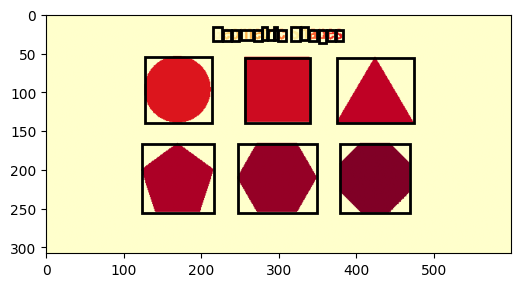

In [3]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh thang xám
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# Phân ngưỡng bằng phương pháp Otsu
thres = threshold_otsu(a)
b = a > thres  # giữ lại những điểm ảnh vượt ngưỡng

# Gán nhãn các vùng liên thông
c = label(b)
cl = Image.fromarray(c.astype(np.uint8))
iio.imsave('label_output.jpg', cl)

# Phân tích đặc trưng của từng vùng
d = regionprops(c)

# Hiển thị ảnh cùng các hộp bao quanh
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')
for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False,
                              edgecolor='black', linewidth=2)
    ax.add_patch(rect)
plt.show()


### 2.2.	Dò tìm cạnh theo chiều dọc

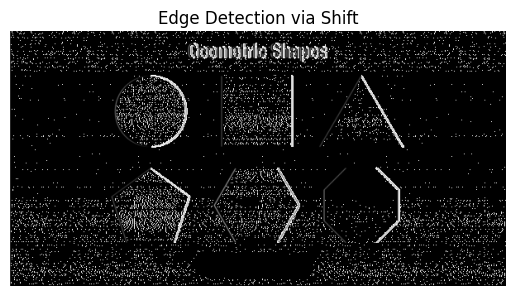

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

# Đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')
a = np.array(data)

# Tính toán biên bằng cách lấy hiệu ảnh gốc và ảnh đã dịch sang phải 1 pixel
bmg = np.abs(a - nd.shift(a, shift=(0, 1), order=0))

# Hiển thị ảnh biên
plt.imshow(bmg, cmap='gray')
plt.title('Edge Detection via Shift')
plt.axis('off')
plt.show()


### 2.3.	Dò tìm cạnh với Sobel Filter

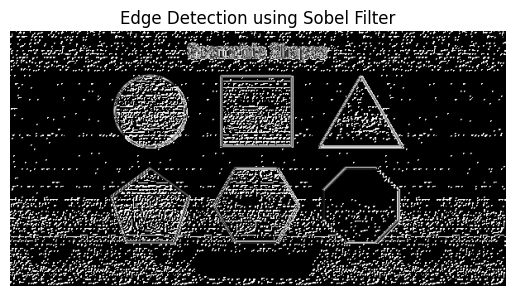

In [5]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh
data = Image.open('geometric.png').convert('L')
img = np.array(data)

# Áp dụng bộ lọc Sobel
sobel_x = nd.sobel(img, axis=0)   # dọc
sobel_y = nd.sobel(img, axis=1)   # ngang

# Tổng độ lớn biên
edge_magnitude = np.abs(sobel_x) + np.abs(sobel_y)

# Hiển thị ảnh biên
plt.imshow(edge_magnitude, cmap='gray')
plt.title('Edge Detection using Sobel Filter')
plt.axis('off')
plt.show()


### 2.4.	Xác định góc của đối tượng

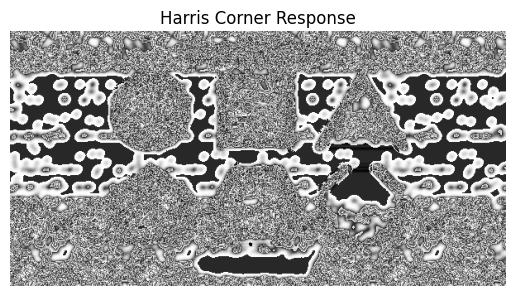

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, axis=0)
    y = nd.sobel(indata, axis=1)
    xl = x ** 2
    yl = y ** 2
    xy = x * y

    # Làm mượt bằng Gaussian filter
    xl = nd.gaussian_filter(xl, sigma=3)
    yl = nd.gaussian_filter(yl, sigma=3)
    xy = nd.gaussian_filter(xy, sigma=3)

    # Tính toán ma trận đặc trưng và phản hồi Harris
    detC = xl * yl - xy**2
    trC = xl + yl
    R = detC - alpha * trC**2
    return R

# Đọc và chuyển ảnh thành mảng grayscale
data = Image.open('geometric.png').convert('L')
img_array = np.array(data)

# Áp dụng hàm Harris
response = Harris(img_array)

# Hiển thị kết quả
plt.imshow(response, cmap='gray')
plt.title('Harris Corner Response')
plt.axis('off')
plt.show()


### 2.5.	Dò tìm hình dạng cụ thể trong ảnh với Hough Transform

#### 2.5.1.	Dò tìm đường thẳng trong ảnh

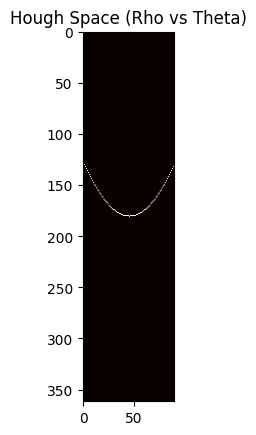

In [7]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))  # Độ dài đường chéo ảnh
    ho = np.zeros((R, 90), float)    # Hough space: trục rho x theta

    w = data.copy()
    ok = True
    theta = np.arange(90) / 180.0 * np.pi  # góc từ 0° đến 90° đổi sang radian
    tp = np.arange(90).astype(float)

    while ok:
        mx = w.max()
        if mx < gamma:
            ok = False
        else:
            v, h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                r_idx = int(rh[i])
                t_idx = int(tp[i])
                if 0 <= r_idx < R and 0 <= t_idx < 90:
                    ho[r_idx, t_idx] += mx
            w[v, h] = 0  # loại điểm đã xử lý
    return ho

# Dữ liệu đầu vào — ảnh nhị phân đơn giản với 1 điểm tại (128,128)
data = np.zeros((256, 256))
data[128, 128] = 1

# Áp dụng Hough Transform
bmg = LineHough(data, 0.5)

# Hiển thị Hough space
plt.imshow(bmg, cmap='hot')
plt.title('Hough Space (Rho vs Theta)')
plt.axis('on')
plt.show()


#### 2.5.2.	Dò tìm đường tròn trong ảnh

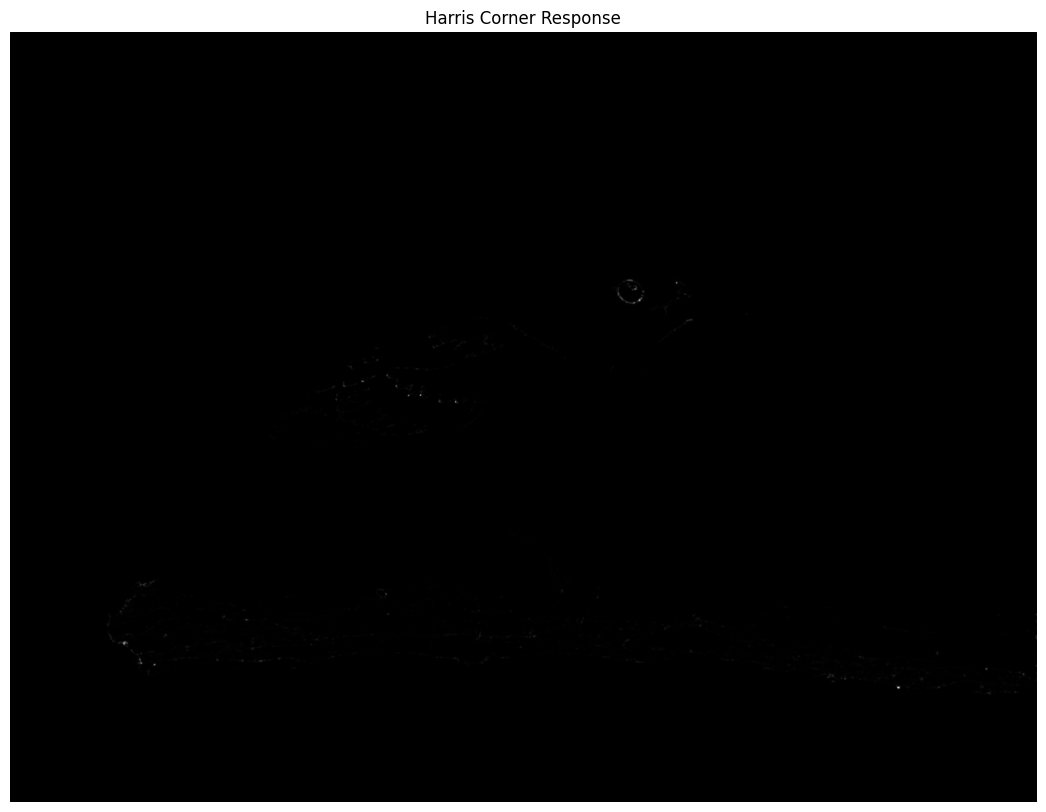

In [8]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

# Đọc ảnh và chuyển sang ảnh xám
data = iio.imread('bird.png')
image_gray = rgb2gray(data)

# Áp dụng thuật toán Harris Corner Detection
coordinate = corner_harris(image_gray, k=0.001)

# Hiển thị ảnh phản hồi góc
plt.figure(figsize=(20, 10))
plt.imshow(coordinate, cmap='gray')
plt.axis('off')
plt.title('Harris Corner Response')
plt.show()


### 2.6.	Image matching

Số lượng điểm khớp: 10


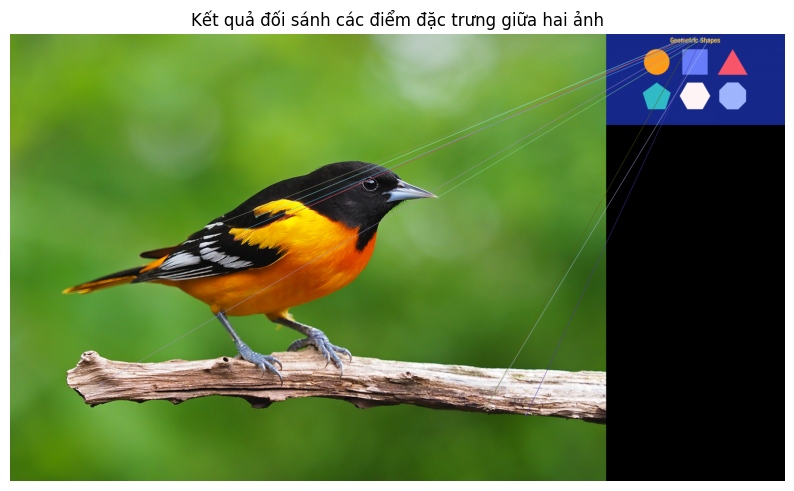

In [14]:
import cv2
import numpy as np

# Đọc ảnh và chuyển sang ảnh xám
gray1_uint8 = cv2.imread('bird.png', cv2.IMREAD_GRAYSCALE)
gray2_uint8 = cv2.imread('geometric.png', cv2.IMREAD_GRAYSCALE)

# Chuyển sang float32 và tính Harris response
gray1 = np.float32(gray1_uint8)
gray2 = np.float32(gray2_uint8)
dst1 = cv2.cornerHarris(gray1, blockSize=2, ksize=3, k=0.04)
dst2 = cv2.cornerHarris(gray2, blockSize=2, ksize=3, k=0.04)

# Ngưỡng để chọn điểm góc mạnh
thresh1 = 0.05 * dst1.max()
thresh2 = 0.05 * dst2.max()
corners1 = dst1 > thresh1
corners2 = dst2 > thresh2

# Lấy tọa độ các điểm góc
pts1 = np.argwhere(corners1)
pts2 = np.argwhere(corners2)

# Tạo đối tượng KeyPoint cho mỗi điểm (dùng cho ORB sau này)
kp_list1 = [cv2.KeyPoint(float(x), float(y), 3) for (y, x) in pts1]
kp_list2 = [cv2.KeyPoint(float(x), float(y), 3) for (y, x) in pts2]

# Vẽ các điểm góc lên ảnh (màu đỏ)
img1_corners = cv2.drawKeypoints(img1, kp_list1, None, color=(0,0,255))
img2_corners = cv2.drawKeypoints(img2, kp_list2, None, color=(0,0,255))
# Tạo đối tượng ORB
orb = cv2.ORB_create()

# Tính descriptor cho từng điểm góc Harris trên ảnh thứ nhất và thứ hai
_, des1 = orb.compute(gray1_uint8, kp_list1)
_, des2 = orb.compute(gray2_uint8, kp_list2)
# Khởi tạo Brute-Force Matcher với distance là Hamming (phù hợp với ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Tìm các cặp khớp giữa hai bộ descriptor
matches = bf.match(des1, des2)

# Sắp xếp các match theo khoảng cách (từ nhỏ đến lớn)
matches = sorted(matches, key=lambda x: x.distance)

# In số điểm khớp được tìm thấy
print("Số lượng điểm khớp:", len(matches))
# Vẽ các kết quả match lên ảnh
img_matches = cv2.drawMatches(img1, kp_list1, img2, kp_list2, matches, None, 
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# Chuyển sang màu RGB để hiển thị bằng matplotlib
img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh kết quả bằng matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(img_matches)
plt.axis('off')
plt.title('Kết quả đối sánh các điểm đặc trưng giữa hai ảnh')
plt.show()

